# Import

In [40]:
import pickle
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load the precomputed SHAP data.
output_file = "shap_output_end.pkl"  # Adjust the path if necessary.
with open(output_file, "rb") as f:
    data = pickle.load(f)

# Assign data to variables
shap_values = data["shap_values"]       # The Explanation object
states_to_explain = data["states_to_explain"]  # Array of state observations, shape (n_samples, STATE_DIM)
feature_names = data["feature_names"]    # List of feature names
action_names = ["right_thigh", "right_leg", "right_foot", "left_thigh", "left_leg", "left_foot"]


# Print data
print("Feature Names:", feature_names)
print("Action Names:", action_names)



Feature Names: ['torso_height', 'torso_angle', 'right_thigh_angle', 'right_leg_angle', 'right_foot_angle', 'left_thigh_angle', 'left_leg_angle', 'left_foot_angle', 'torso_x_velocity', 'torso_z_velocity', 'torso_angular_velocity', 'right_thigh_angular_velocity', 'right_leg_angular_velocity', 'right_foot_angular_velocity', 'left_thigh_angular_velocity', 'left_leg_angular_velocity', 'left_foot_angular_velocity']
Action Names: ['right_thigh', 'right_leg', 'right_foot', 'left_thigh', 'left_leg', 'left_foot']


# Summary Plots for Each Action Dimension

This summary plot (often called a beeswarm plot) displays the contribution (SHAP value) of each input feature to the model’s output for a specific action dimension, aggregated over all samples.

- Dots: Each dot represents one state sample; its horizontal position shows how much that feature pushed the output to increase or decrease compared to a baseline.

- Color: The color indicates the actual feature value (typically, red means high and blue means low).

- Interpretation: The features at the top of the plot have the greatest overall influence on that action’s decision, letting you identify which state aspects are most critical for that control signal.

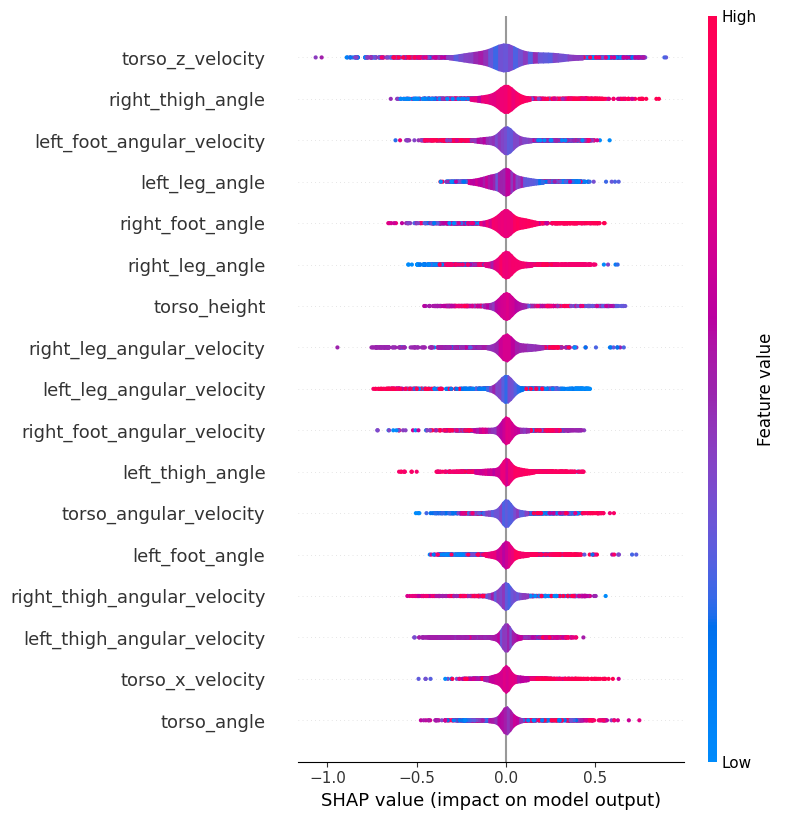

In [41]:
num_actions = shap_values.values.shape[-1]

shap.summary_plot(shap_values.values.reshape(-1, len(feature_names)), shap_values.data.repeat(num_actions, axis=0), feature_names=feature_names, plot_type="violin")

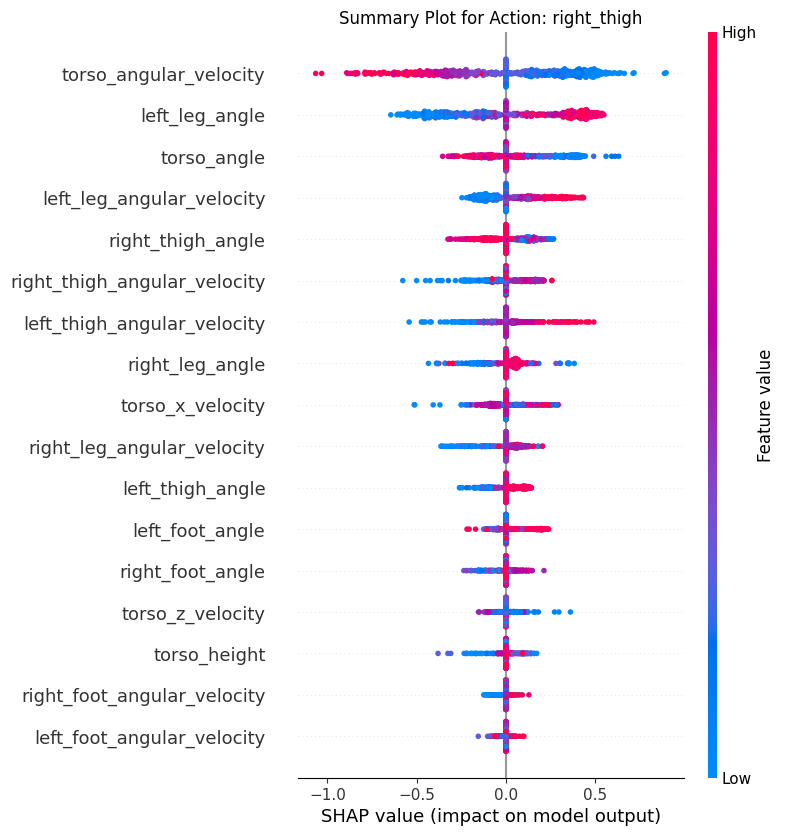

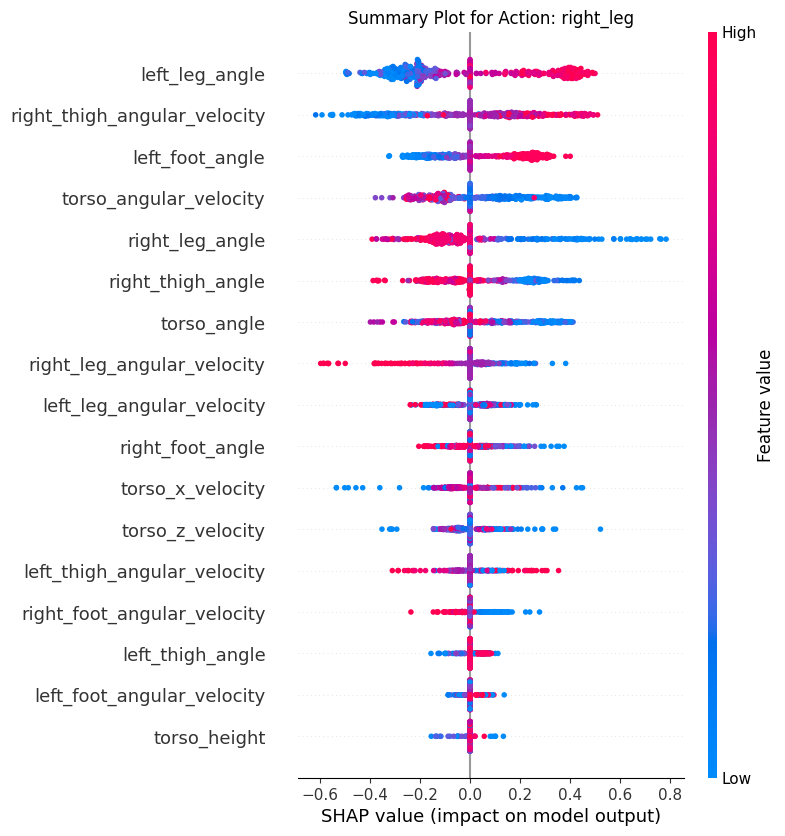

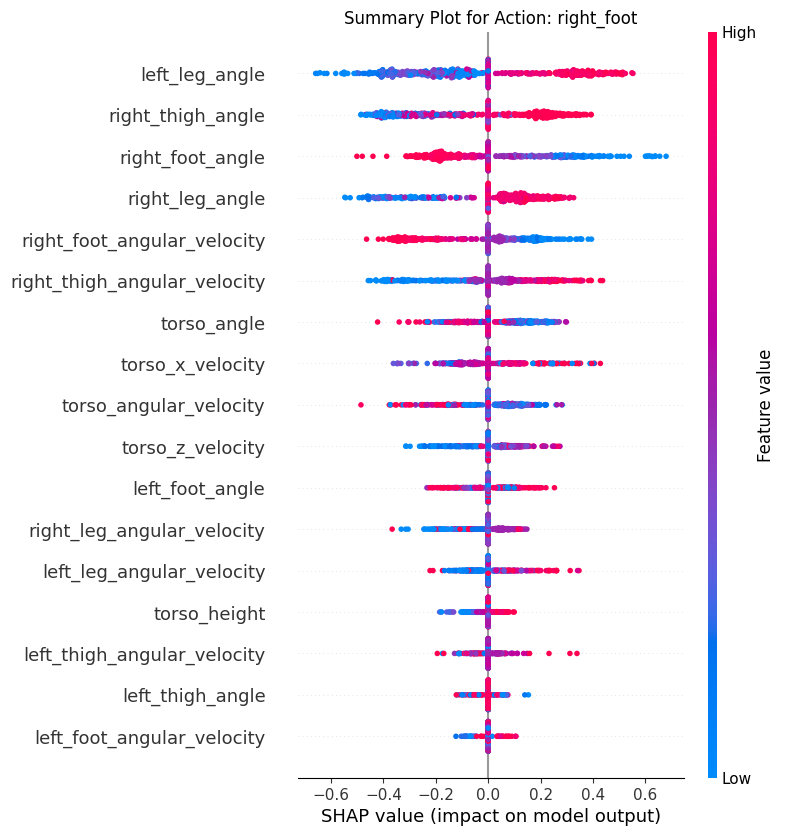

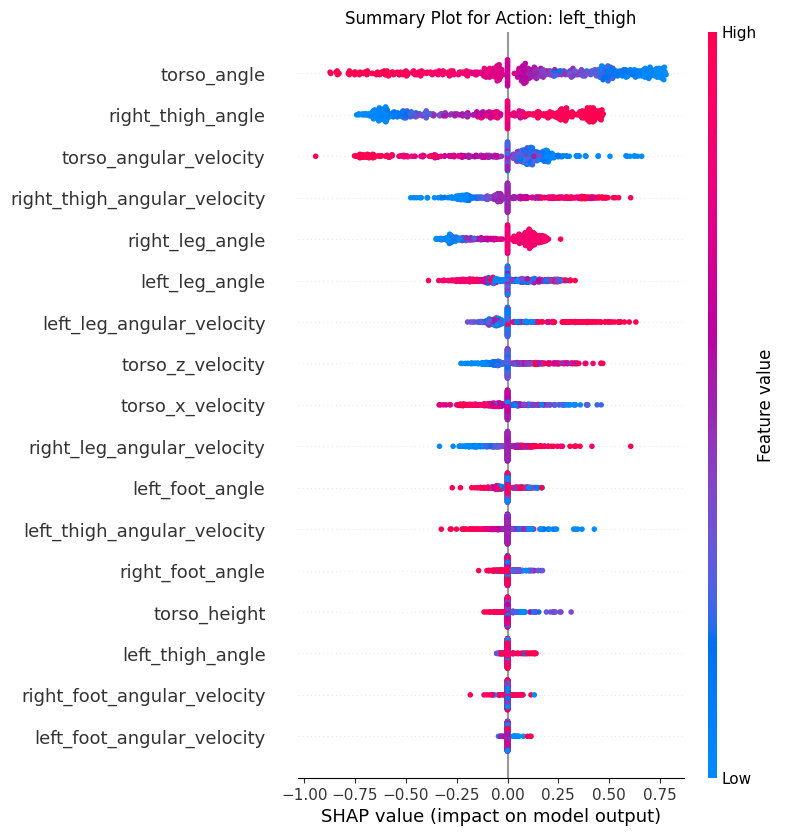

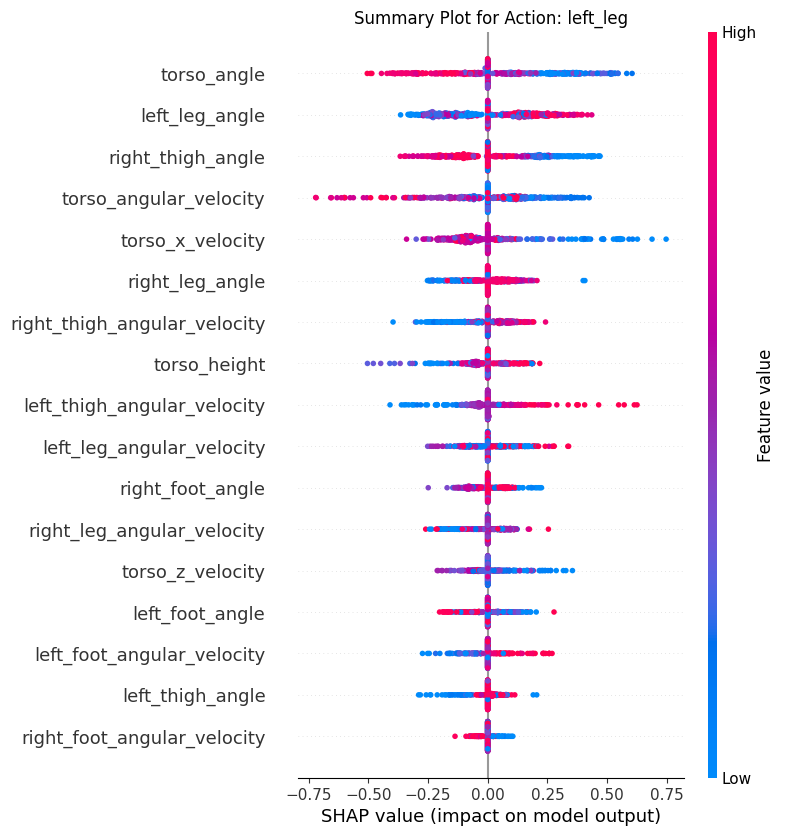

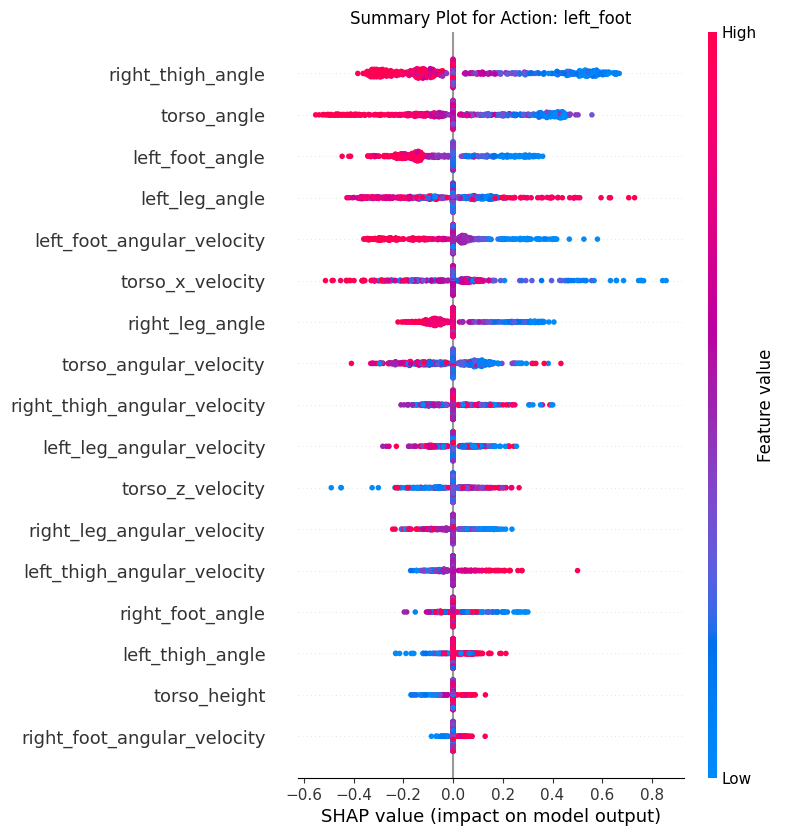

In [42]:
for idx in range(num_actions):
    action_label = action_names[idx]  # Use descriptive action name
    # Extract SHAP values for this action dimension (shape: (n_samples, STATE_DIM))
    action_shap = shap_values.values[:, :, idx]
    # Produce the summary plot—title will show the descriptive action name.
    shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names, show=False)
    plt.title(f"Summary Plot for Action: {action_label}")
    plt.show()

# Heatmap of Mean Absolute SHAP Values

This heatmap aggregates the mean absolute SHAP values for each input feature across all samples, with each column corresponding to one action dimension.

- Color Intensity: A darker (or more vibrant) cell indicates that a feature has a higher average influence on that action’s output.

- Comparison: This visualization allows you to quickly compare which features are most important across different control signals.

- Interpretation: Look for rows (features) with consistently high values; these are the features that the model relies on most across various actions.

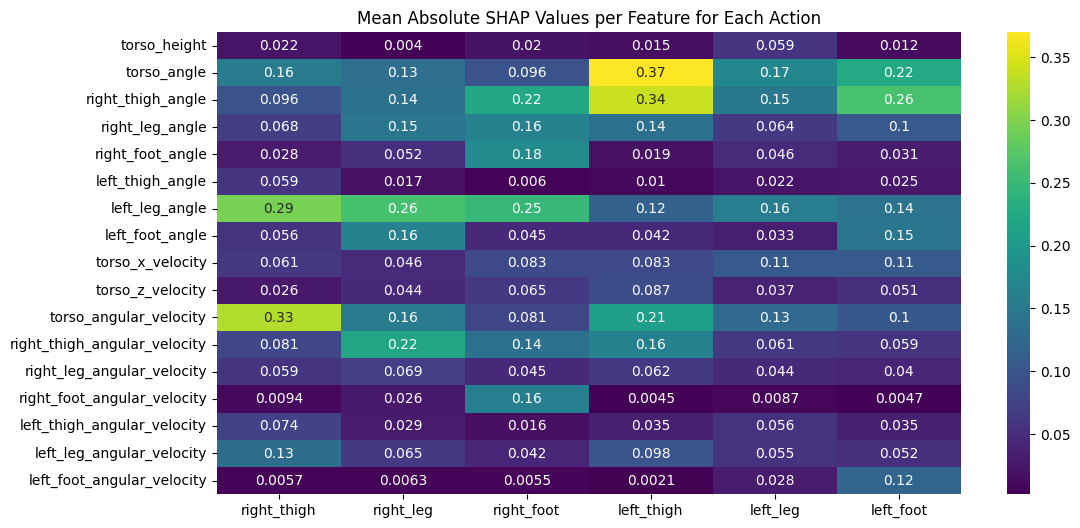

In [43]:
num_features = states_to_explain.shape[1]
action_feature_importance = np.zeros((num_actions, num_features))

# Compute the average absolute SHAP value for each feature for every action.
for a in range(num_actions):
    action_shap = np.abs(shap_values.values[:, :, a])
    action_feature_importance[a, :] = action_shap.mean(axis=0)

# Create a DataFrame where columns use the descriptive action names.
df = pd.DataFrame(action_feature_importance.T, columns=action_names, index=feature_names)

plt.figure(figsize=(12, 6))
sns.heatmap(df, annot=True, cmap="viridis")
plt.title("Mean Absolute SHAP Values per Feature for Each Action")
plt.show()



# Dependence Plot for a Selected Feature

The dependence plot shows how the SHAP value for a single feature (e.g., “torso_angle”) varies with its feature value across the dataset for a specified action.

- X-Axis: The actual value of the selected feature.

- Y-Axis: The corresponding SHAP value, indicating how that feature’s value is impacting the prediction.

- Color: By default, points are colored by the value of another interacting feature. You can override this behavior to reduce complexity.

- Interpretation: This plot helps reveal the nature of the relationship (linear, non-linear, threshold effects) between the feature value and its impact on the output.

Feature Names: ['torso_height', 'torso_angle', 'right_thigh_angle', 'right_leg_angle', 'right_foot_angle', 'left_thigh_angle', 'left_leg_angle', 'left_foot_angle', 'torso_x_velocity', 'torso_z_velocity', 'torso_angular_velocity', 'right_thigh_angular_velocity', 'right_leg_angular_velocity', 'right_foot_angular_velocity', 'left_thigh_angular_velocity', 'left_leg_angular_velocity', 'left_foot_angular_velocity']


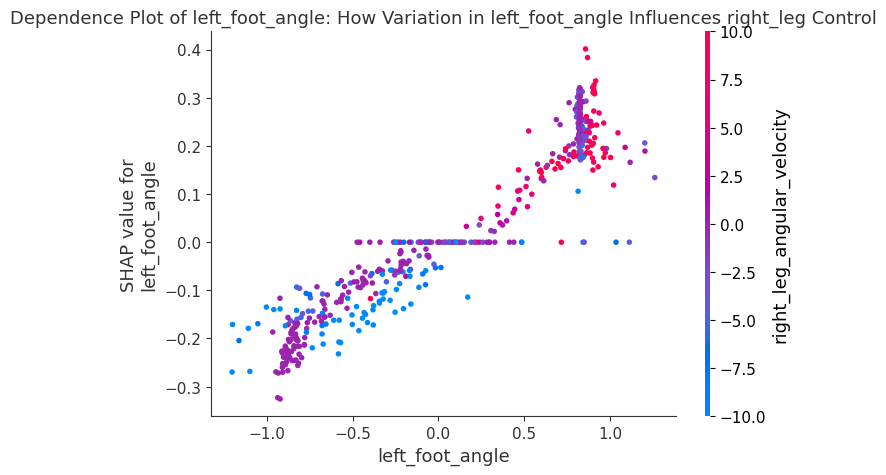

In [44]:
print("Feature Names:", feature_names)
selected_feature = "left_foot_angle"
action_name = "right_leg"
action_dim_to_plot = action_names.index(action_name)

shap.dependence_plot(selected_feature, shap_values.values[:, :, action_dim_to_plot], states_to_explain, feature_names=feature_names,
                    title = f"Dependence Plot of {selected_feature}: How Variation in {selected_feature} Influences {action_name} Control")


# Decision Plot for Individual Sample Analysis

This decision plot breaks down a single prediction by showing how each input feature contributes cumulatively—from a base (or expected) value to the final output—for a specific action.

- Cumulative Contributions: The plot sequentially adds (or subtracts) each feature’s contribution, clarifying how the final decision was made.

- Expected/Base Value: This value (often shown at the start) is what the model would output in the absence of any specific feature influence.

- Interpretation: By following the progression, you can understand which features had the largest impact on pushing the output higher or lower, helping you grasp the reasoning behind a single prediction.

Using sample #123 where 'torso_z_velocity' has peak impact on action 'left_thigh'


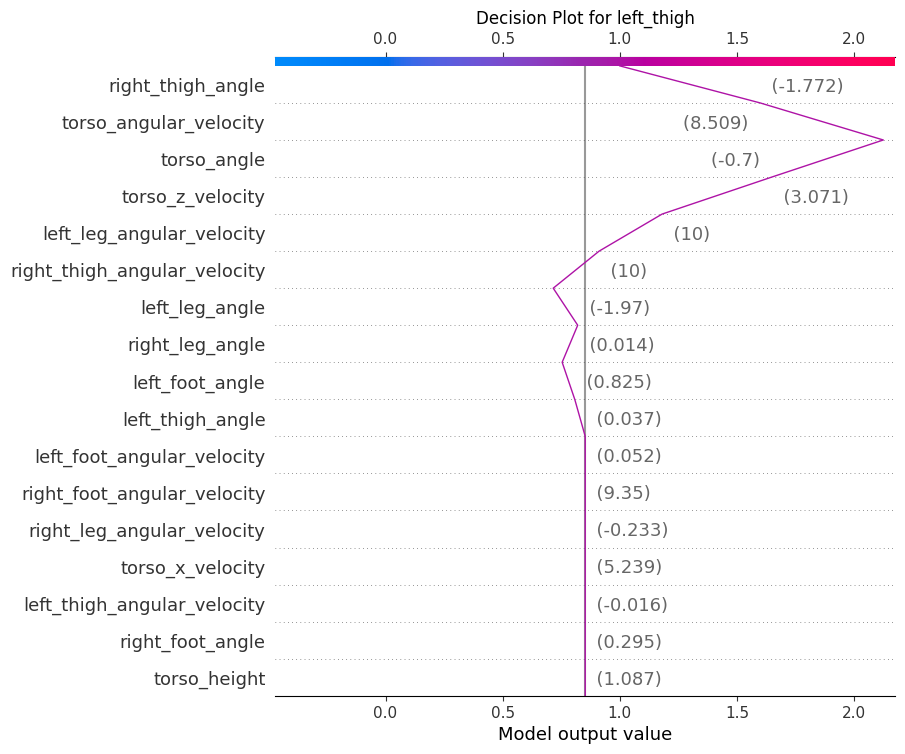

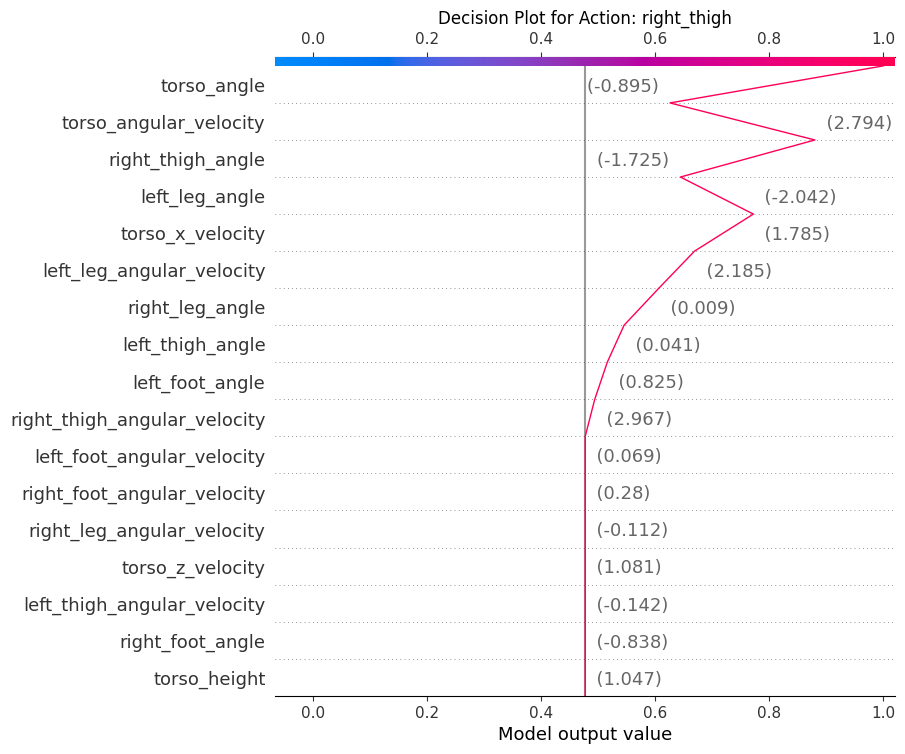

In [45]:
# 1) pick your feature
feat_name = "torso_z_velocity"
feat_idx  = feature_names.index(feat_name)

# 2) pick the action that this feature influences most
#    (mean(|SHAP|) across samples)
fv = shap_values.values[:, feat_idx, :]
mean_abs  = np.mean(np.abs(fv), axis=0)
action_dim = int(np.argmax(mean_abs))

# 3) pick the single state where this feature’s effect on that action is largest
sv_action  = shap_values.values[:, feat_idx, action_dim]
sample_ix  = int(np.argmax(np.abs(sv_action)))

print(f"Using sample #{sample_ix} where {feat_name!r} has peak impact on action '{action_names[action_dim]}'")

# 3) grab base, feature values, and shap values
base_val   = shap_values.base_values[action_dim]
feat_vals  = states_to_explain[sample_ix]
shap_loc   = shap_values.values[sample_ix, :, action_dim]

# 4) plot, highlighting your feature
shap.decision_plot(base_val, shap_loc, feat_vals, feature_names=feature_names,
    title=f"Decision Plot for {action_names[action_dim]}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sample_index = 42  # Choose a sample to inspect

action_dim_to_plot = action_names.index("right_thigh") 

expected_value = shap_values.base_values[action_dim_to_plot]

# Extract SHAP values for the chosen sample and action.
sample_shap = shap_values.values[sample_index, :, action_dim_to_plot]

shap.decision_plot(expected_value, sample_shap, states_to_explain[sample_index], feature_names=feature_names, title=f"Decision Plot for Action: {action_names[action_dim_to_plot]}")


# Can also do a force_plot, need to spend more time looking at this
# force_plot = shap.force_plot(expected_value, shap_values.values[sample_index, :, action_dim_to_plot], states_to_explain[sample_index], feature_names=feature_names, matplotlib=True)

plt.show()
